[torchdiffeq example](https://github.com/rtqichen/torchdiffeq/blob/master/examples/cnf.py)을 스스로 이해하기 쉬운 형태로 변경함.

좋은 소스 제공 감사합니다.

In [1]:
import os
from tqdm import tqdm
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.datasets import make_circles
from sklearn.datasets import make_swiss_roll
import torch
from torch import nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint
# from torchdiffeq import odeint

In [2]:
NITERS = 2000
EVAL_INTERVAL = 400
LR = 1e-3
N_SAMPLES = 512
N_VIZ_SAMPLES = 10000
N_VIZ_TIME_STEPS = 41
WIDTH = 64
IN_OUT_DIM = 2
HIDDEN_DIM = 32
DEVICE = "cuda:3"
RESULTS_DIR = "./results"
N_SAMPLES = 2**8

T0 = 0
T1 = 10

In [3]:
# def sample_from_circles(n_samples):
#     data, _ = make_circles(n_samples=n_samples, noise=0.06, factor=0.5)
#     return torch.Tensor(data).type(torch.float32).to(DEVICE)


def sample_from_swiss_roll(n_samples):
    data, _ = make_swiss_roll(n_samples=n_samples, noise=0.5)
    return torch.Tensor(data[:, [0, 2]] / 10).to(DEVICE)

In [4]:
def get_batch(n_samples):
    # x = sample_from_circles(n_samples=n_samples)
    x = sample_from_swiss_roll(n_samples=n_samples)
    logp_diff_t1 = torch.zeros(n_samples, 1).type(torch.float32).to(DEVICE)  # 초기값은 0

    return (x, logp_diff_t1)

`CNF` = $f = \dfrac{d\mathbf{z}(t)}{dt}$

$\dfrac{d\mathbf{z}(t)}{dt} = uh(w^T \mathbf{z}(t) + b)$

$\dfrac{d\mathbf{z}(t)}{dt} = \sum_{n=1}^{M}f_n(\mathbf{z}(t)), \qquad \dfrac{d \log p(\mathbf{z}(t))}{dt} = \sum_{n=1}^M tr(\dfrac{\partial f_n}{\partial\mathbf{z}})$

In [5]:
class HyperNetwork(nn.Module):
    """https://arxiv.org/abs/1609.09106"""

    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        # predict params
        params = t.reshape(1, 1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)

        # restructure
        params = params.reshape(-1)
        W = params[: self.blocksize].reshape(self.width, self.in_out_dim, 1)

        U = params[self.blocksize : 2 * self.blocksize].reshape(self.width, 1, self.in_out_dim)

        G = params[2 * self.blocksize : 3 * self.blocksize].reshape(self.width, 1, self.in_out_dim)
        U = U * torch.sigmoid(G)

        B = params[3 * self.blocksize :].reshape(self.width, 1, 1)
        return [W, B, U]

In [6]:
def trace_df_dz(f, z):
    """Calculates the trace (equals to det) of the Jacobian df/dz."""
    sum_diag = 0.0
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()  # [batch_size]

In [7]:
class CNF(nn.Module):

    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.hyper_net = HyperNetwork(in_out_dim, hidden_dim, width)

    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            W, B, U = self.hyper_net(t)

            Z = torch.unsqueeze(z, 0).repeat(self.width, 1, 1)

            h = torch.tanh(torch.matmul(Z, W) + B)
            dz_dt = torch.matmul(h, U).mean(0)  # mean by width dim

            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)

        return (dz_dt, dlogp_z_dt)

In [8]:
func = CNF(in_out_dim=IN_OUT_DIM, hidden_dim=HIDDEN_DIM, width=WIDTH).to(DEVICE)
optimizer = optim.Adam(func.parameters(), lr=LR)

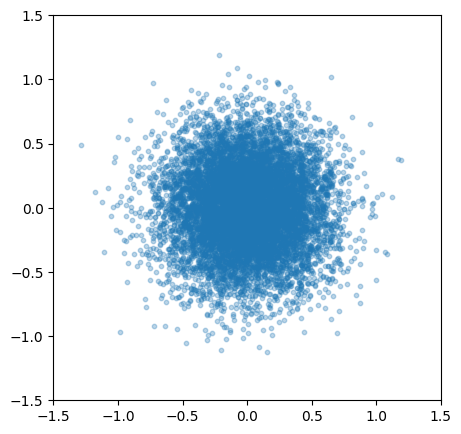

In [9]:
# pdf of z0
mean = torch.zeros(IN_OUT_DIM).type(torch.float32)
cov = torch.zeros(IN_OUT_DIM, IN_OUT_DIM).type(torch.float32)
cov.fill_diagonal_(0.1)
p_z0 = torch.distributions.MultivariateNormal(loc=mean.to(DEVICE), covariance_matrix=cov.to(DEVICE))

z0_sample = p_z0.sample([N_VIZ_SAMPLES])

plt.figure(figsize=(5, 5))
plt.scatter(*z0_sample.cpu().T, alpha=0.3, s=10)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.show()

$$
\begin{align*}
ObjectiveFunction = \log p(\mathbf{z}(t0)) - \int_{t0}^{t1} \sum_{n=1}^M tr(\dfrac{\partial f_n(\mathbf{z}(t), t)}{\partial \mathbf{z}(t)}) dt = \log p(\mathbf{x})
\end{align*}
$$

 20%|█▉        | 399/2000 [02:55<15:55,  1.67it/s]

Iter: 400, running avg loss: 1.1004


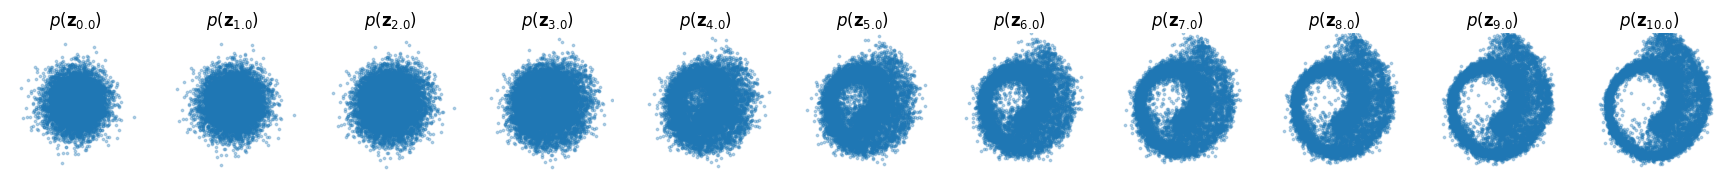

 40%|███▉      | 799/2000 [08:23<17:06,  1.17it/s]

Iter: 800, running avg loss: 0.7053


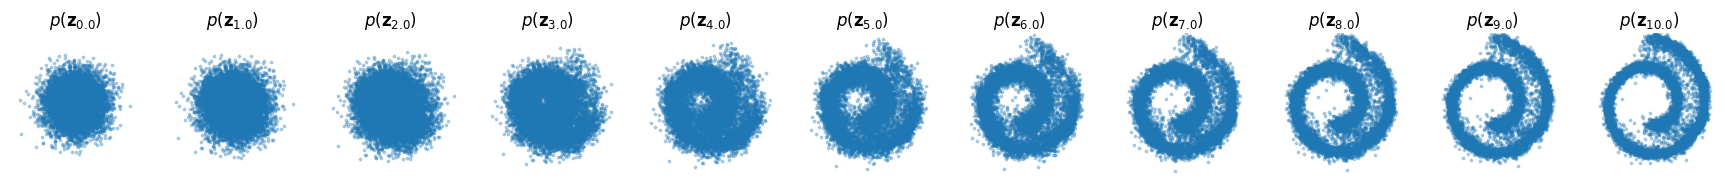

 60%|█████▉    | 1199/2000 [14:10<12:15,  1.09it/s]

Iter: 1200, running avg loss: 0.6613


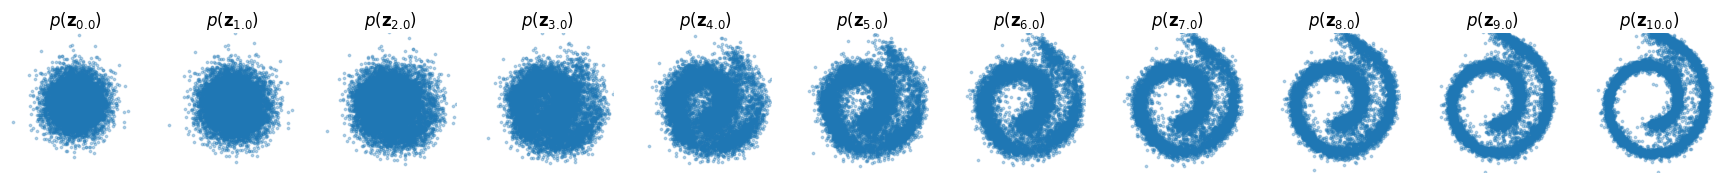

 80%|███████▉  | 1599/2000 [20:38<06:30,  1.03it/s]

Iter: 1600, running avg loss: 0.6714


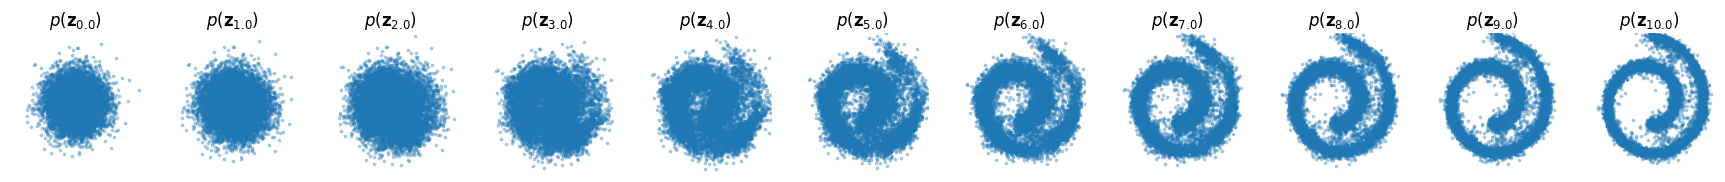

100%|█████████▉| 1999/2000 [27:29<00:01,  1.08s/it]

Iter: 2000, running avg loss: 0.6871


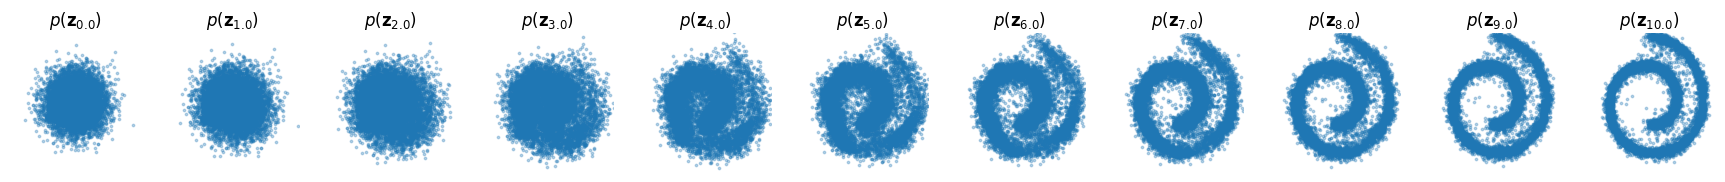

100%|██████████| 2000/2000 [27:31<00:00,  1.21it/s]


In [10]:
for itr in tqdm(range(1, NITERS + 1)):
    optimizer.zero_grad()

    x, logp_diff_t1 = get_batch(N_SAMPLES)

    z_t, logp_diff_t = odeint(
        func,
        (x, logp_diff_t1),
        torch.tensor([T1, T0]).type(torch.float32).to(DEVICE),  # focus on [T1, T0] (not [T0, T1])
        atol=1e-5,
        rtol=1e-5,
        method="dopri5",
    )

    z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

    logp_x = p_z0.log_prob(z_t0).to(DEVICE) - logp_diff_t0.view(-1)
    loss = -logp_x.mean(0)

    loss.backward()
    optimizer.step()

    if itr % EVAL_INTERVAL == 0:
        print("Iter: {}, running avg loss: {:.4f}".format(itr, loss.item()))
        with torch.no_grad():
            z_t0 = p_z0.sample([N_VIZ_SAMPLES]).to(DEVICE)
            logp_diff_t0 = torch.zeros(N_VIZ_SAMPLES, 1).type(torch.float32).to(DEVICE)

            time_space = np.linspace(T0, T1, 11)
            z_t_samples, _ = odeint(
                func,
                (z_t0, logp_diff_t0),
                torch.tensor(time_space).to(DEVICE),  # [T0, T1] for generation
                atol=1e-5,
                rtol=1e-5,
                method="dopri5",
            )

            fig, ax = plt.subplots(1, 11, figsize=(22, 1.8))
            for i in range(11):
                t = time_space[i]
                z_sample = z_t_samples[i]
                ax[i].scatter(*z_sample.detach().cpu().numpy().T, alpha=0.3, s=3)
                ax[i].set_xlim(-1.5, 1.5)
                ax[i].set_ylim(-1.5, 1.5)
                ax[i].set_axis_off()
                ax[i].set_title("$p(\mathbf{z}_{" + str(t) + "})$")
            plt.show()

In [11]:
N_VIZ_SAMPLES = 30000
N_VIZ_TIMESTEPS = 41

target_sample, _ = get_batch(N_VIZ_SAMPLES)

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

with torch.no_grad():
    # Generate evolution of samples
    z_t0 = p_z0.sample([N_VIZ_SAMPLES]).to(DEVICE)
    logp_diff_t0 = torch.zeros(N_VIZ_SAMPLES, 1).type(torch.float32).to(DEVICE)

    z_t_samples, _ = odeint(
        func,
        (z_t0, logp_diff_t0),
        torch.tensor(np.linspace(T0, T1, N_VIZ_TIMESTEPS)).to(DEVICE),  # [T0, T1] for generation
        atol=1e-5,
        rtol=1e-5,
        method="dopri5",
    )

    # Generate evolution of density
    x = np.linspace(-1.5, 1.5, 100)
    y = np.linspace(-1.5, 1.5, 100)
    points = np.vstack(np.meshgrid(x, y)).reshape([2, -1]).T

    z_t1 = torch.tensor(points).type(torch.float32).to(DEVICE)
    logp_diff_t1 = torch.zeros(z_t1.shape[0], 1).type(torch.float32).to(DEVICE)

    z_t_density, logp_diff_t = odeint(
        func,
        (z_t1, logp_diff_t1),
        torch.tensor(np.linspace(T1, T0, N_VIZ_TIMESTEPS)).to(DEVICE),  # [T1, T0] for calculating probability
        atol=1e-5,
        rtol=1e-5,
        method="dopri5",
    )

    # Create plots for each timestep
    for t, z_sample, z_density, logp_diff in zip(
        np.linspace(T0, T1, N_VIZ_TIMESTEPS), z_t_samples, z_t_density, logp_diff_t
    ):
        fig = plt.figure(figsize=(12, 4), dpi=200)
        plt.tight_layout()
        plt.axis("off")
        plt.margins(0, 0)
        fig.suptitle(f"{t:.2f}s")

        ax1 = fig.add_subplot(1, 3, 1)
        ax1.set_title("Target")
        ax1.get_xaxis().set_ticks([])
        ax1.get_yaxis().set_ticks([])
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_title("Samples")
        ax2.get_xaxis().set_ticks([])
        ax2.get_yaxis().set_ticks([])
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_title("Log Probability")
        ax3.get_xaxis().set_ticks([])
        ax3.get_yaxis().set_ticks([])

        ax1.hist2d(*target_sample.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])

        ax2.hist2d(*z_sample.detach().cpu().numpy().T, bins=300, density=True, range=[[-1.5, 1.5], [-1.5, 1.5]])

        logp = p_z0.log_prob(z_density) - logp_diff.view(-1)
        ax3.tricontourf(*z_t1.detach().cpu().numpy().T, np.exp(logp.detach().cpu().numpy()), 200)

        plt.savefig(
            os.path.join(RESULTS_DIR, f"cnf-viz-{int(t*1000):05d}.jpg"),
            pad_inches=0.2,
            bbox_inches="tight",
        )
        plt.close()

    img, *imgs = [Image.open(f) for f in sorted(glob.glob(os.path.join(RESULTS_DIR, f"cnf-viz-*.jpg")))]
    img.save(
        fp=os.path.join(RESULTS_DIR, "cnf-viz.gif"),
        format="GIF",
        append_images=imgs,
        save_all=True,
        duration=250,
        loop=0,
    )

print("Saved visualization animation at {}".format(os.path.join(RESULTS_DIR, "cnf-viz.gif")))


Saved visualization animation at ./results/cnf-viz.gif
